Importing Important Dependency

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import random
import string
import seaborn as sea
%matplotlib inline
import scipy
from plotly import graph_objs as go
import plotly.express as exp
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings('ignore')

import os

from palettable.colorbrewer.qualitative import Pastel1_7
nltk.download('stopwords')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Unzipping The Trained Models

In [2]:
!unzip models.zip


Archive:  models.zip
   creating: models/
   creating: models/model_neg/
  inflating: models/model_neg/meta.json  
   creating: models/model_neg/ner/
  inflating: models/model_neg/ner/cfg  
  inflating: models/model_neg/ner/model  
  inflating: models/model_neg/ner/moves  
  inflating: models/model_neg/tokenizer  
   creating: models/model_neg/vocab/
  inflating: models/model_neg/vocab/key2row  
  inflating: models/model_neg/vocab/lexemes.bin  
  inflating: models/model_neg/vocab/strings.json  
  inflating: models/model_neg/vocab/vectors  
   creating: models/model_neu/
  inflating: models/model_neu/meta.json  
   creating: models/model_neu/ner/
  inflating: models/model_neu/ner/cfg  
  inflating: models/model_neu/ner/model  
  inflating: models/model_neu/ner/moves  
  inflating: models/model_neu/tokenizer  
   creating: models/model_neu/vocab/
  inflating: models/model_neu/vocab/key2row  
  inflating: models/model_neu/vocab/lexemes.bin  
  inflating: models/model_neu/vocab/strings.jso

Reading The Data

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# checking the shape of datasets
print(train.shape)
print(test.shape)

# checking for information in training data i.e., null values
print(train.info())

# dropping null values from the dataset
train.dropna(inplace = True)

# checking the testing dataset
print(test.info())

# the test data does not contain any null values



(27481, 4)
(3534, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB
None
       textID  ... sentiment
0  cb774db0d1  ...   neutral
1  549e992a42  ...  negative
2  088c60f138  ...  negative
3  9642c003ef  ...  negative
4  358bd9e861  ...  negative

[5 rows x 4 columns]
            textID     

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


EDA

In [ ]:
# Data analysis

print(train.head())

# selected text is part of the text

print(train.describe())

# distribution of tweets in the training set

temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by = 'text', ascending= False)
temp.style.background_gradient(cmap='Reds')

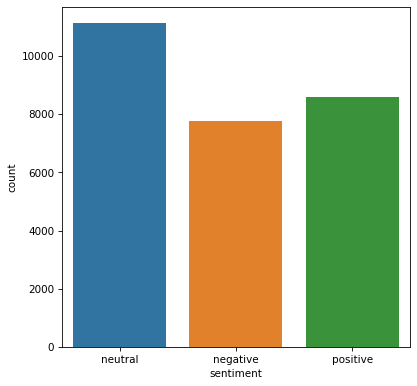

In [5]:
# plot for sentiments i.e., positive, negative, neural.
plt.figure(figsize=(6, 6), dpi = 75)
sea.countplot(x = 'sentiment', data = train)

In [6]:
# Creating a Funnel-Chart for sentiment representation
fig = go.Figure(go.Funnelarea(text =temp.sentiment,
                              values = temp.text,
                              title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}))
fig.show()

In [7]:
# Using Jaccard Similarity Score between Text and Selected_Text which will later be used to gives the text containing the sentiment(Selected text)
  def jaccard(s1, s2):
    a = set(s1.lower().split())
    b = set(s2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

  result_jaccard = []


In [8]:
  for ind, row in train.iterrows():
     phrase1 = row.text
     phrase2 = row.selected_text

     jaccard_score = jaccard(phrase1, phrase2)
     result_jaccard.append([phrase1, phrase2, jaccard_score])



In [9]:
jaccard = pd.DataFrame(result_jaccard, columns= ["text", "selected_text", "jaccard_score"])
train = train.merge(jaccard, how = 'outer')


In [10]:
train['no_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split()))
train['no_words_text'] = train['text'].apply(lambda x:len(str(x).split()))
train['diff_of_words'] = train['no_words_text'] - train['no_words_ST']


In [11]:
train.head(10)

,textID,text,selected_text,sentiment,jaccard_score,no_words_ST,no_words_text,diff_of_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,12,12,0
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,1,14,13
7,50e14c0bb8,Soooo high,Soooo high,neutral,1.000000,2,2,0
8,e050245fbd,Both of you,Both of you,neutral,1.000000,3,3,0
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,0.500000,5,10,5


In [12]:
hist_data = [train['no_words_ST'],train['no_words_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=True, colors= ["#ff3300", "#bf4080"])
fig.update_layout(title_text='Numeric Distribution of words')
fig.update_layout(
    autosize= False,
    width=500,
    height=600,
    paper_bgcolor=" #00cc88",
)
fig.show()

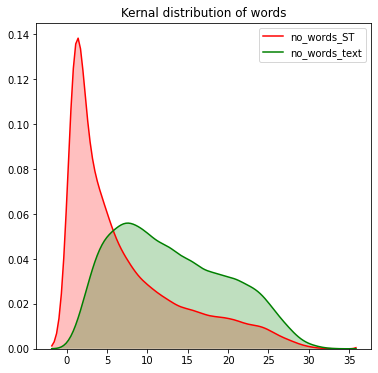

In [13]:
# plotting the kernal distribution of words
plt.figure(figsize = (6, 6))
p1 = sea.kdeplot(train['no_words_ST'], shade = True, color = "r").set_title("Kernal distribution of words")
p1 = sea.kdeplot(train['no_words_text'], shade = True, color = 'g') 

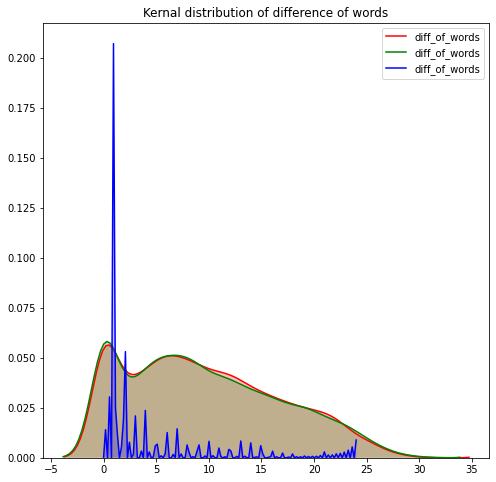

In [14]:
# plotting the kernal distribution plot for the difference of words in the different sentiment
plt.figure(figsize = (8, 8))
p1 = sea.kdeplot(train[train['sentiment']== 'positive']['diff_of_words'], shade = True, color  = "r").set_title('Kernal distribution of difference of words')
                 
p2 = sea.kdeplot(train[train['sentiment']== 'negative']['diff_of_words'], shade = True, color  = "g")

p3 = sea.kdeplot(train[train['sentiment']== 'neutral']['diff_of_words'], shade = True, color  = "b")

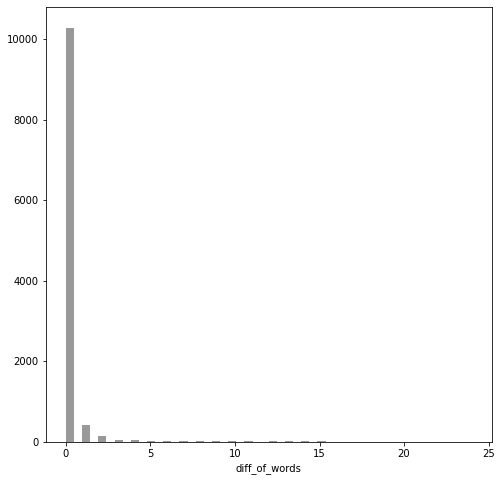

In [15]:
# plotting the neutral tweets with a distribution plot as most of the values for difference in number of words were zero
plt.figure(figsize = (8, 8))
sea.distplot(train[train['sentiment']== 'neutral']['diff_of_words'],color = "#000000", kde = False)

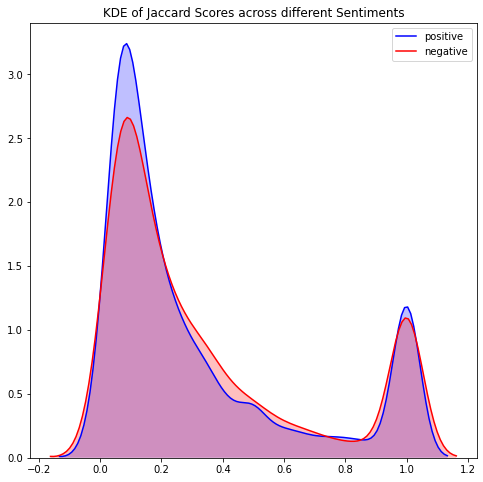

In [16]:
#Plotting the Kernal Distribution of the Jaccard Score across different sentiments
plt.figure(figsize=(8, 8))
p1=sea.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sea.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

Text(0.5, 1.0, 'Jaccard Distribution for neutral sentiment')

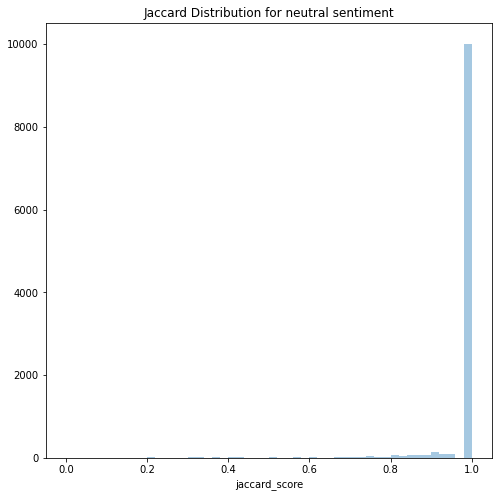

In [17]:
# plotting the kernal distribution of jaccard score of the Neutral Sentiment with a Distribution Plot
plt.figure(figsize= (8, 8))
sea.distplot(train[train['sentiment']== 'neutral']['jaccard_score'], kde = False).set_title("Jaccard Distribution for neutral sentiment")

In [18]:
# one interesting idea would be to check tweets which have number of words lesss than 3 in text,
# because there the text might be completely used as text
k = train[train['no_words_text']<=2]
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [19]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,no_words_ST,no_words_text,diff_of_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


Cleaning the Data

In [20]:
# Make text lowercase, remove text in square brackets,remove links,remove punctuation
# and remove words containing numbers
def clean_text(text):
   text = str(text).lower()
   text = re.sub('\[.*?\]', '', text)
   text = re.sub('https?://\S+|www\.\S+', '', text)
   text = re.sub('<.*?>+', '', text)
   text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
   text = re.sub('\n', '', text)
   text = re.sub('\w*\d\w*', '', text)
   return text  

In [21]:
train['text'] = train['text'].apply(lambda x: clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x: clean_text(x))

In [22]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,no_words_ST,no_words_text,diff_of_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


Most Common Words in the Selected Words

In [24]:
train['temp_list'] = train['selected_text'].apply(lambda x: str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap = 'Greens')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [25]:
fig = exp.bar(temp, x = "count", y = "Common_words", orientation = 'h',
             title = "Common Words in the selected text", 
             width = 500, height = 500, color = 'Common_words' )
fig.show()

In [26]:
def remove_stopword(x):
  return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [27]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:, :]
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap = 'Greens')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


Most Common Words in the Text Column

In [28]:
train['temp_list1'] = train['text'].apply(lambda x: str(x).split())
train["temp_list1"] = train['temp_list1'].apply(lambda x: remove_stopword(x))
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))



temp = temp.iloc[1:, :]
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap = 'Greens')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [29]:
fig = exp.bar(temp, x= 'count', y= 'Common_words', color='Common_words',
              orientation='h', width=600, height= 600, title='Most Common words in text')
              
fig.show()

Most Common Words: Sentiment Wise

In [30]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']


In [31]:
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ["Common_words", "count"]
temp_positive.style.background_gradient(cmap = 'Blues')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [32]:
fig = exp.bar(temp_positive, x= 'count', y= 'Common_words', title = 'Most Common Positive Words',
             color = 'Common_words', orientation= 'h', width= 600, height= 600)
fig.show()

In [33]:
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:, :]
temp_negative.columns= ["Common_words", "count"]
temp_negative.style.background_gradient(cmap = 'Greens')

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [34]:
fig = exp.bar(temp_negative, x='count', y='Common_words', color= 'Common_words',
              orientation='h', width= 600, height= 600)
fig.show()

In [35]:
top= Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.iloc[1:,:]
temp_neutral.columns = ['Common_words', 'count']
temp_neutral.style.background_gradient(cmap= 'Reds')

,Common_words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427
10,lol,427


In [36]:
fig= exp.bar(temp_neutral, x='count', y= 'Common_words',
             width=600, height= 600, orientation='h', color= 'Common_words', title= 'Most Common Neutral Words')
fig.show()

In [37]:
print(train['temp_list1'])

0                                   [id, responded, going]
1                            [sooo, sad, miss, san, diego]
2                                         [boss, bullying]
3                                [interview, leave, alone]
4          [sons, couldnt, put, releases, already, bought]
                               ...                        
27475    [wish, could, come, see, u, denver, husband, l...
27476    [ive, wondered, rake, client, made, clear, net...
27477    [yay, good, enjoy, break, probably, need, hect...
27478                                              [worth]
27479            [flirting, going, atg, smiles, yay, hugs]
Name: temp_list1, Length: 27480, dtype: object


Unique words in each segment:


* Positive
* Negative
* Neutral






In [38]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]


In [39]:
def words_unique(sentiment, numwords, raw_words):
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother.append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

Positive Words

In [40]:
Unique_positive= words_unique('positive', 20, raw_text)
print("The top 20 positive unique words are as follows:")
Unique_positive.style.background_gradient(cmap = 'Blues')

The top 20 positive unique words are as follows:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


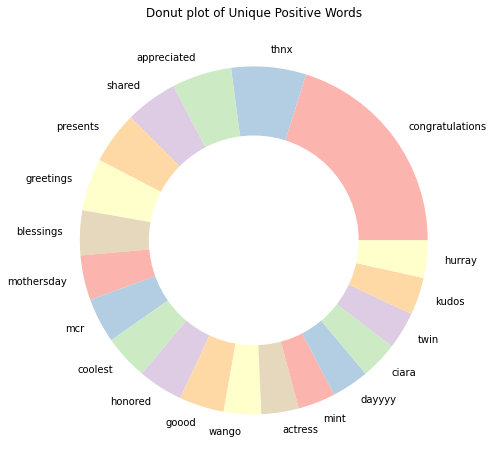

In [41]:
# Plotting the donut chart of Unique Positive Words
plt.figure(figsize = (8, 8))
my_circle= plt.Circle((0,0), 0.6, color= 'White')
plt.pie(Unique_positive['count'], labels= Unique_positive.words, colors= Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Donut plot of Unique Positive Words')
plt.show()

Negative Words

In [42]:
Unique_negative= words_unique('negative', 20, raw_text)
print("The top 20 negative unique words are as follows:")
Unique_positive.style.background_gradient(cmap = 'Blues')

The top 20 negative unique words are as follows:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


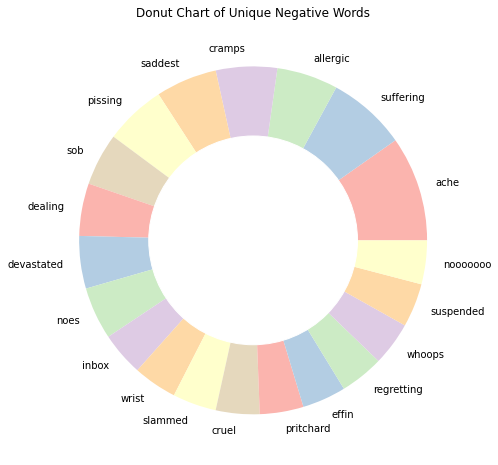

In [43]:
# Plotting the donut chart of Unique Negative Words
plt.figure(figsize= (8, 8))
my_circle= plt.Circle((0,0), 0.6, color='white')
plt.pie(Unique_negative['count'], labels= Unique_negative.words, colors= Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Donut Chart of Unique Negative Words")
plt.show()

Neutral Words

In [44]:
Unique_neutral = words_unique('neutral', 20, raw_text)
print("Top 20 neutral words are as follows:")
Unique_neutral.style.background_gradient(cmap = 'Oranges')

Top 20 neutral words are as follows:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


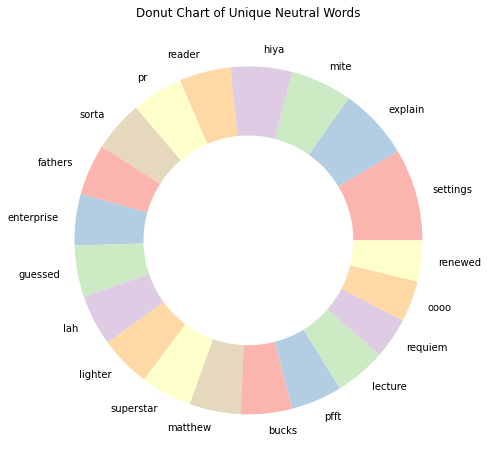

In [45]:
# Plotting the donut chart of Unique Neutral Words
plt.figure(figsize= (8, 8))
my_circle= plt.Circle((0,0), 0.6, color='white')
plt.pie(Unique_neutral['count'], labels= Unique_neutral.words, colors= Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Donut Chart of Unique Neutral Words")
plt.show()

Visualising the data with WordClouds:


*   WordClouds in Neutral Tweets
*   WordClouds in Positive Tweets
*   WordClouds in Negative Tweets


In [46]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  


WordClouds of Neutral Words

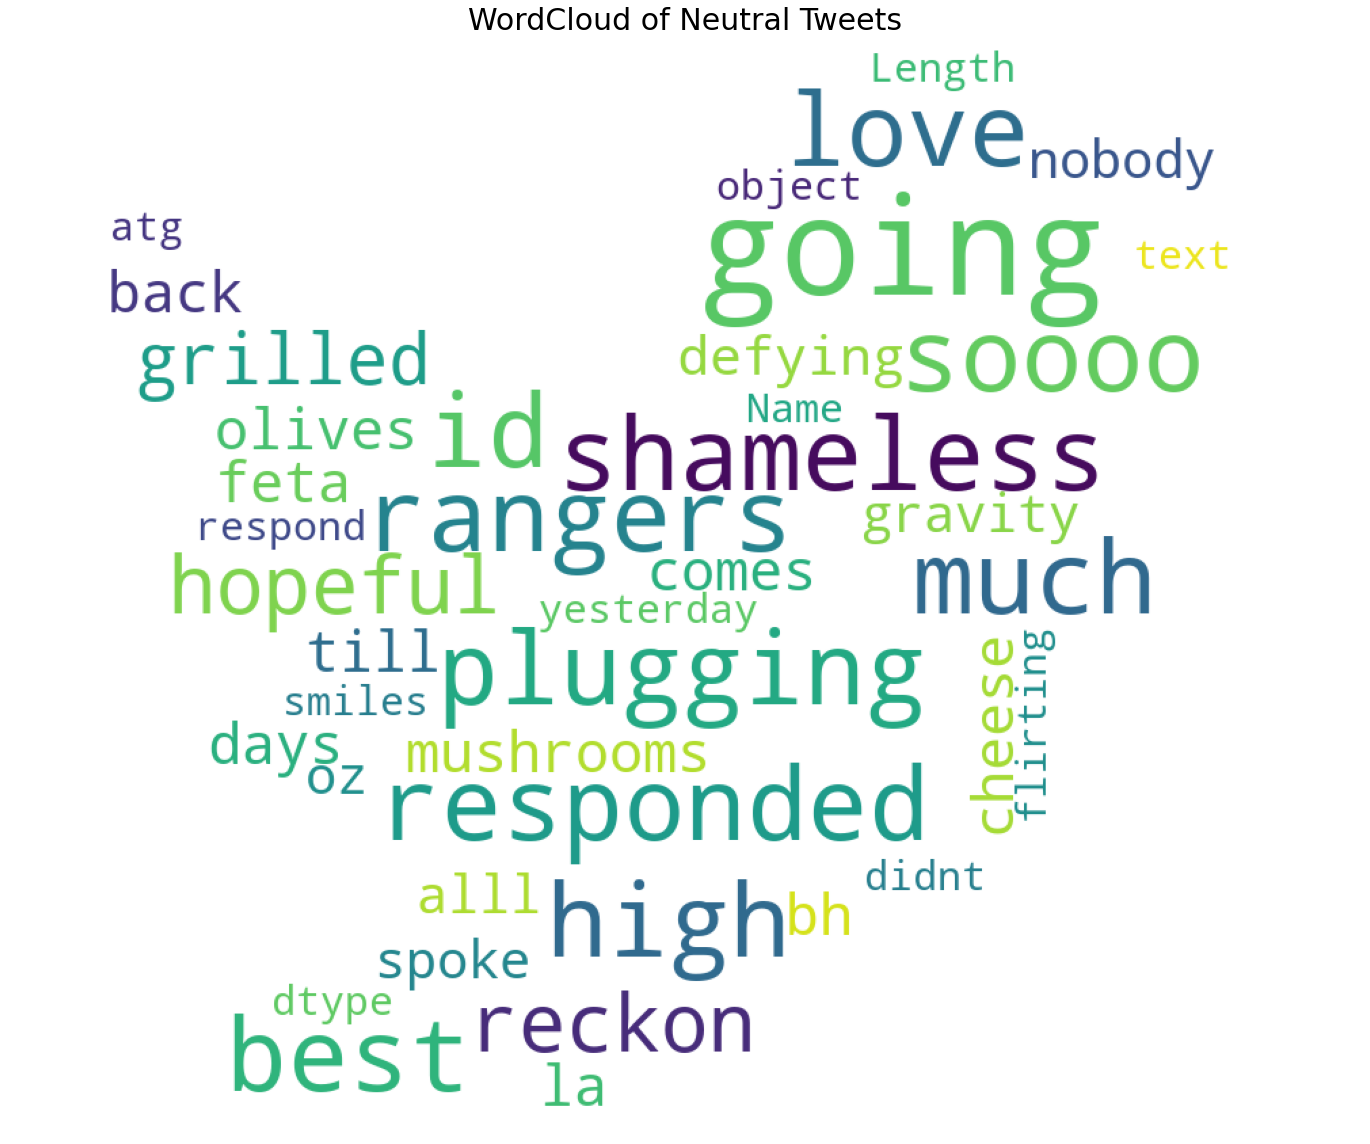

In [47]:
pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

WordClouds of Positive Words

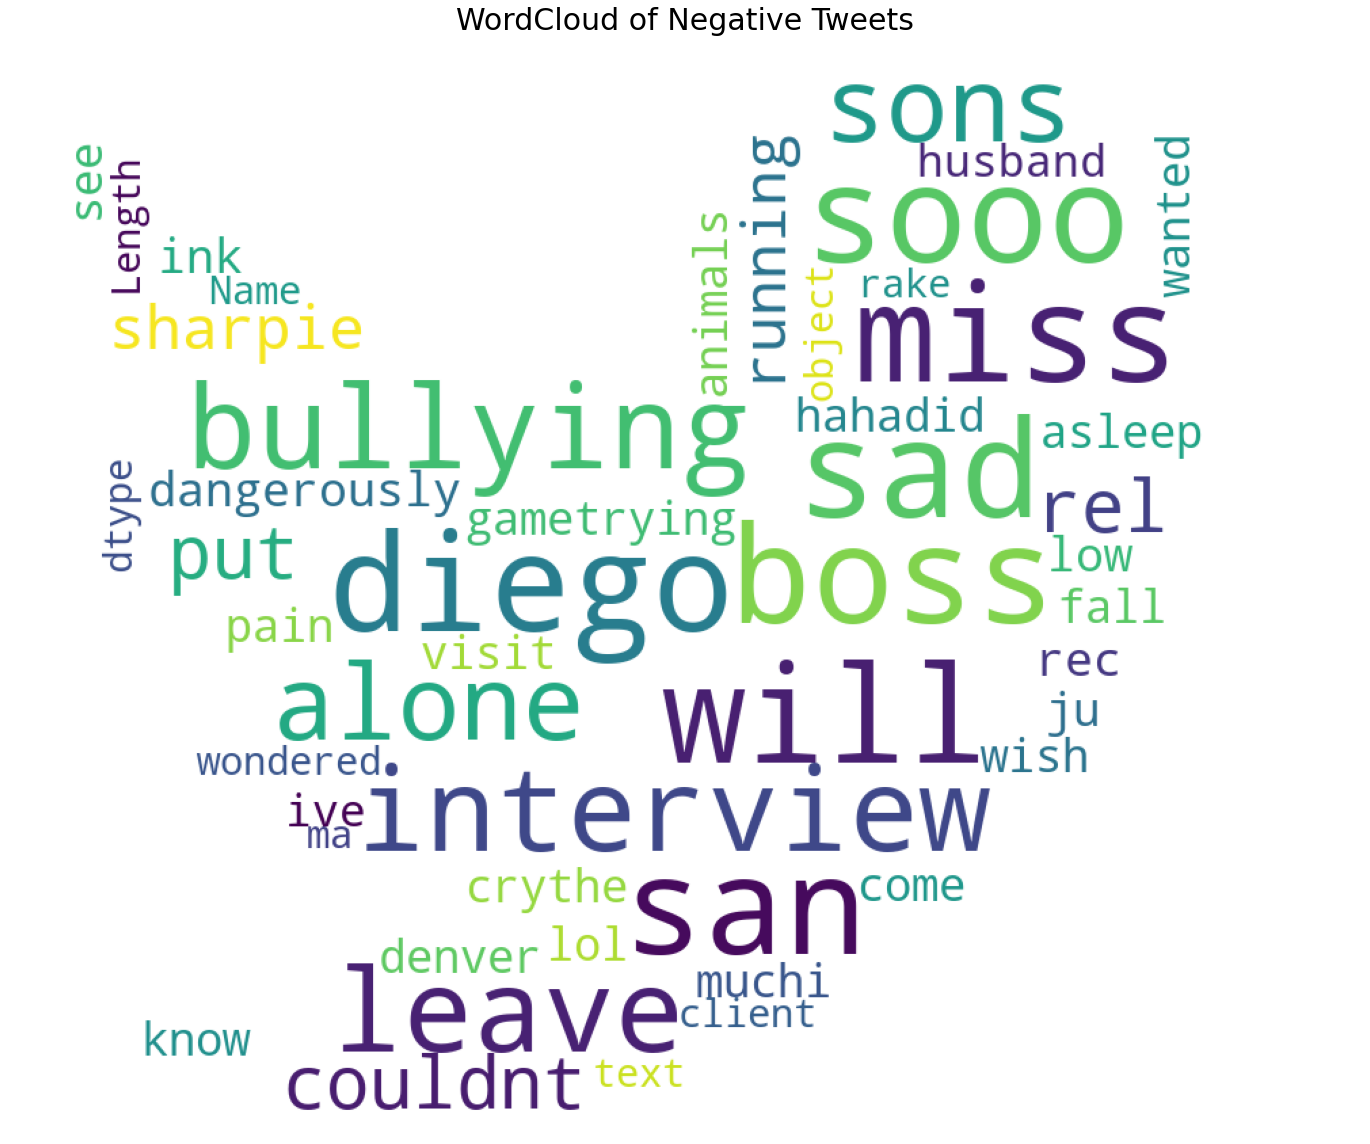

In [48]:
pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(Negative_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Negative Tweets")

WordClouds of Positive Words

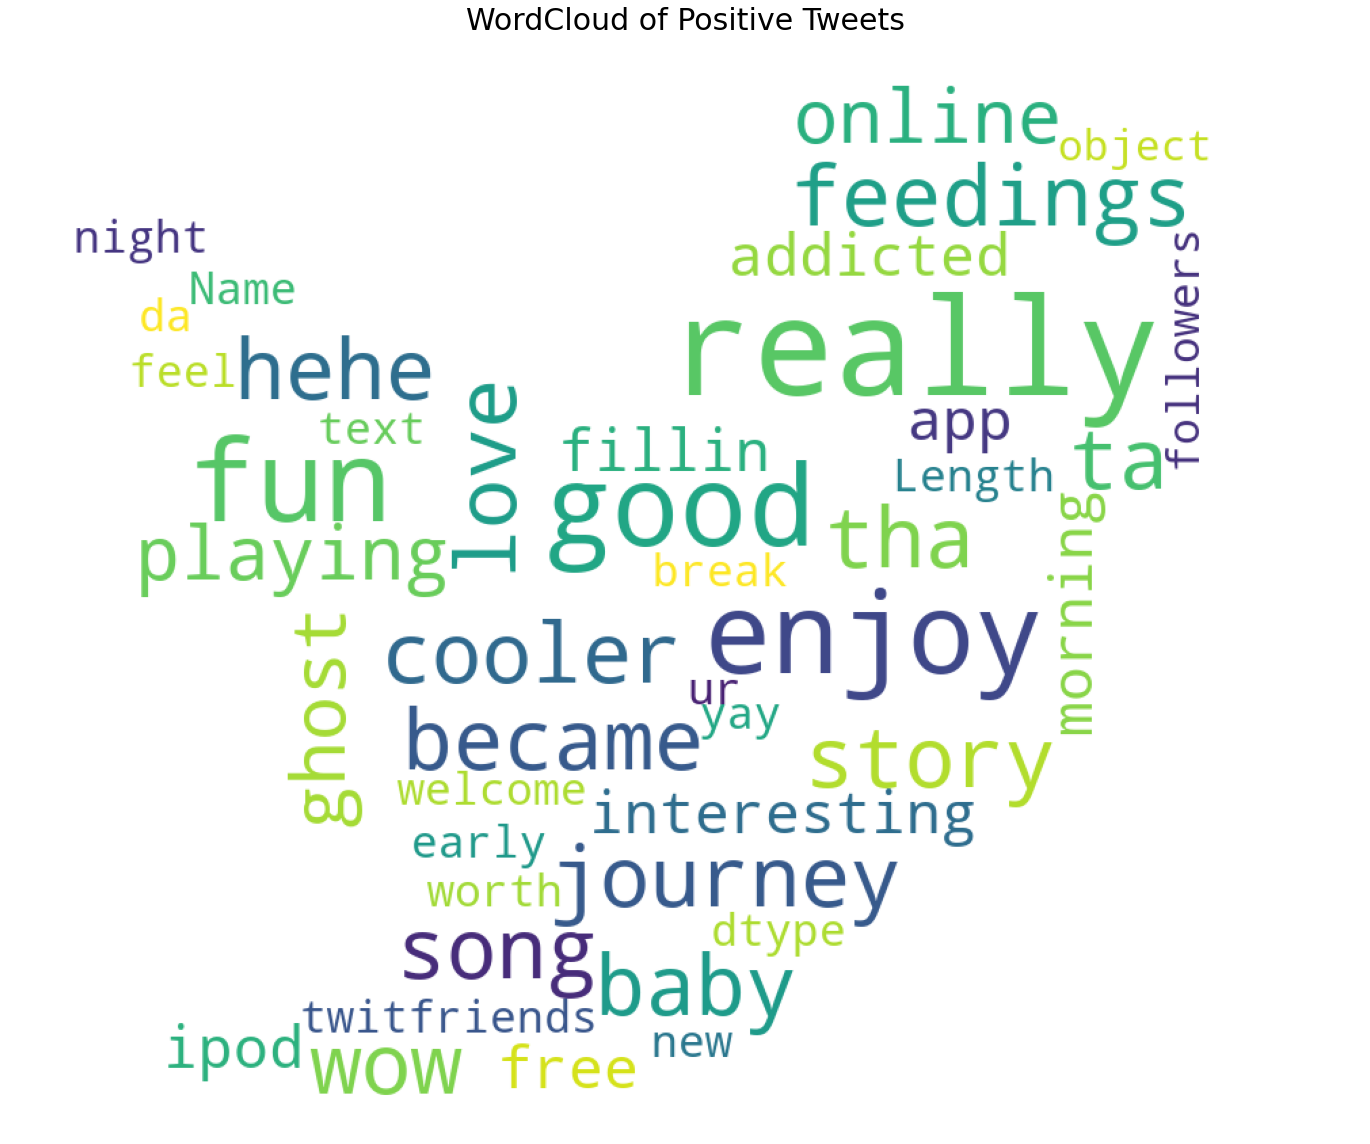

In [49]:
pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(Positive_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Positive Tweets")

Working on the problem with NER model

In [50]:
df_train= pd.read_csv('train.csv')
df_test= pd.read_csv('test.csv')

In [51]:
df_train['Num_words_text']= df_train['text'].apply(lambda x: len(str(x).split()))
df_train= df_train[df_train['Num_words_text']>=3]

In [52]:
def save_model(output_dir, nlp, new_model_name):
  output_dir= f'/content/{output_dir}'
  if output_dir is not None:        
       if not os.path.exists(output_dir):
           os.makedirs(output_dir)
       nlp.meta["name"] = new_model_name
       nlp.to_disk(output_dir)
       print("Saved model to", output_dir)

In [53]:
def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop=0.5,   # dropout - make it harder to memorise data
                            losses=losses, 
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [54]:
# The following function returns Model output path
def get_model_out_path(sentiment):
    
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = '/content/models/model_pos'
    elif sentiment == 'negative':
        model_out_path = '/content/models/model_neg'
    else:
      model_out_path= '/content/models/model_neu'
    return model_out_path

In [55]:
def get_training_data(sentiment):
    '''
    Returns Training data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data


Training models for Positive and Negative tweets

In [57]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|███▎      | 1/3 [00:53<01:46, 53.00s/it]

Losses {'ner': 34244.00662493255}


 67%|██████▋   | 2/3 [01:43<00:52, 52.36s/it]

Losses {'ner': 30880.384544619395}


100%|██████████| 3/3 [02:35<00:00, 51.78s/it]

Losses {'ner': 28916.409518578297}
Saved model to /content//content/models/model_pos


In [58]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
train(train_data, model_path, n_iter=3, model=None)

  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|███▎      | 1/3 [00:48<01:37, 48.97s/it]

Losses {'ner': 31943.33569048255}


 67%|██████▋   | 2/3 [01:37<00:48, 48.69s/it]

Losses {'ner': 28810.313151910177}


100%|██████████| 3/3 [02:25<00:00, 48.51s/it]

Losses {'ner': 27548.109258468146}
Saved model to /content//content/models/model_neg


Predicting with the trained model

In [66]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [67]:
MODELS_BASE_PATH= '/content/models/'

In [68]:
selected_texts= []

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
    for index, row in df_test.iterrows():
      text = row.text
      output_str = ""
      if row.sentiment == 'neutral' or len(text.split()) <= 2:
        selected_texts.append(text)
      elif row.sentiment == 'positive':
        selected_texts.append(predict_entities(text, model_pos))
      else:
        selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts


Loading Models  from  /content/models/


In [69]:
df_test.head(10)

,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,exciting
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,Recession
3,01082688c6,happy bday!,positive,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,I like it!!
5,726e501993,that`s great!! weee!! visitors!,positive,visitors!
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,HATES
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative,blocked
8,e64208b4ef,and within a short time of the last clue all ...,neutral,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,What did you get? My day is alright.. haven`...
